##Generate a music video

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%%capture
! pip install diffusers transformers

In [3]:
from matplotlib import pyplot as plt
import numpy as np

def plot_array(y):
    x = np.arange(y.shape[0])

    # plotting

    plt.title("Line graph")

    plt.xlabel("X axis")

    plt.ylabel("Y axis")

    plt.plot(x, y, color ="red")
    return plt.show()

In [4]:
import librosa
from IPython.display import Audio

n_mels = 512
fps = 30
offset = 11
duration = 10
num_parts = 3

audio_input = "/content/drive/MyDrive/audio_samples/1975_bagsy_30sec.wav"

wav, sr = librosa.load(audio_input)

#wav, sr = librosa.load(librosa.example('choice'), offset=offset, duration=duration)
Audio(wav, rate=sr)

audio_sections = []
audio_sections_duration = []

samples_part = duration * sr

for i in range(0, len(wav), samples_part):
    end = i + samples_part
    audio_part = wav[i:end]
    audio_sections.append(audio_part)
    audio_sections_duration.append(len(audio_part)/sr)

Audio(audio_sections[2], rate=sr)

0


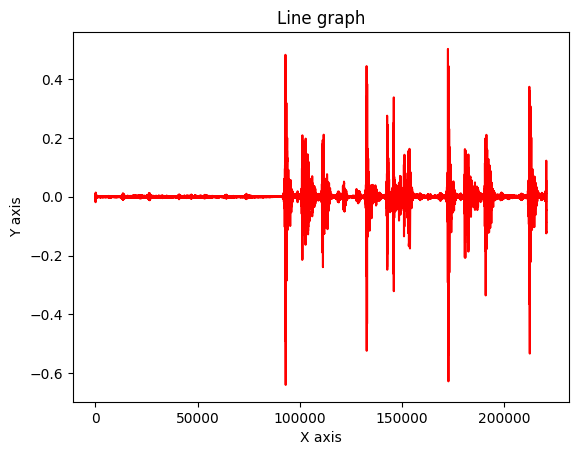

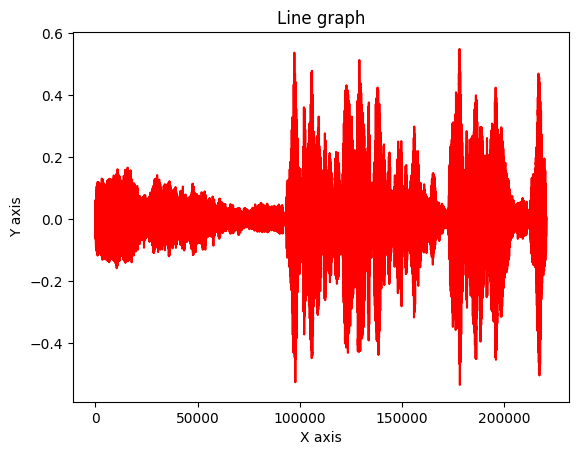

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


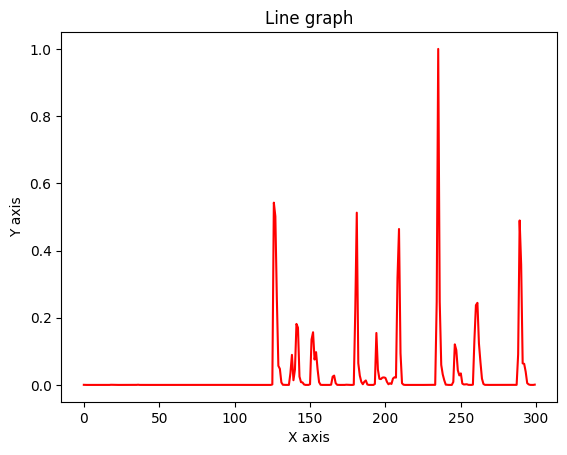

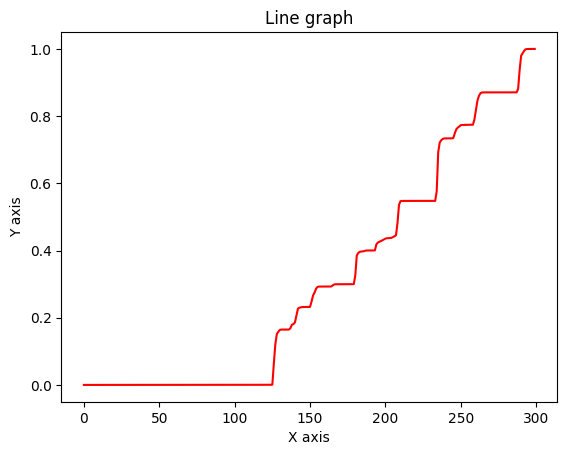

1


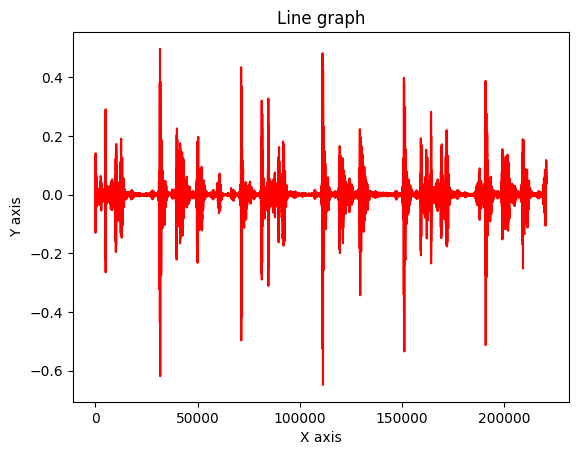

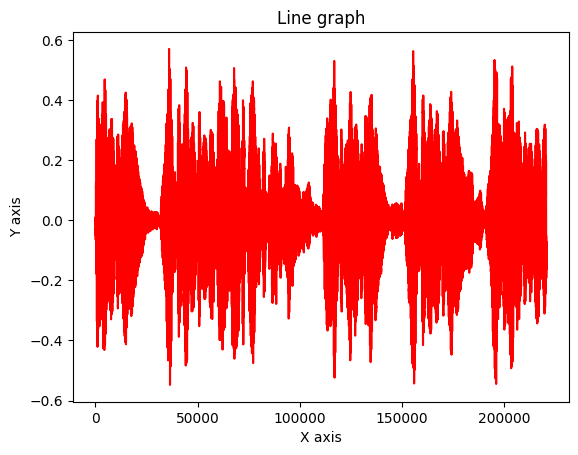

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


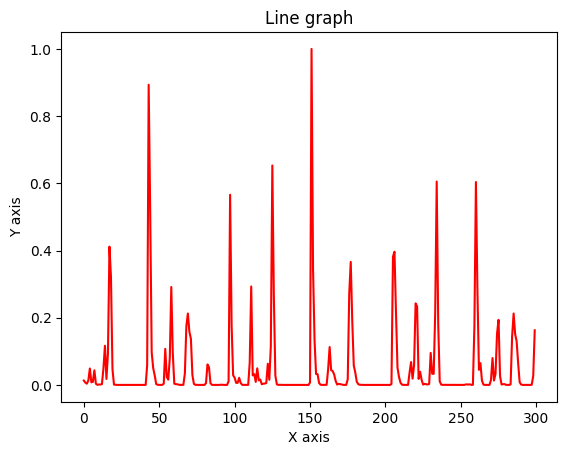

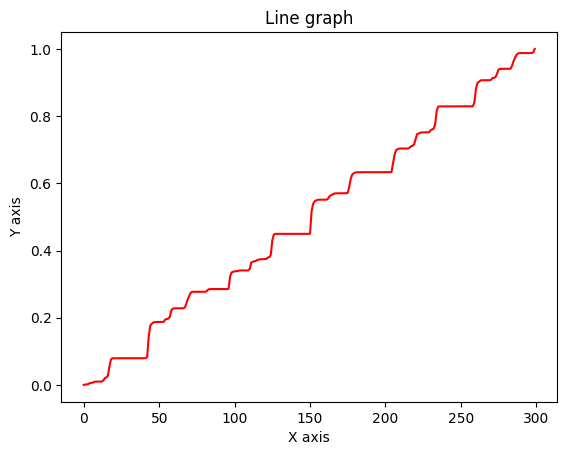

2


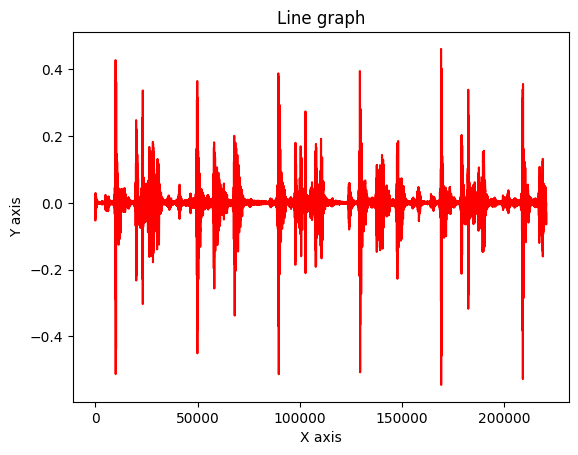

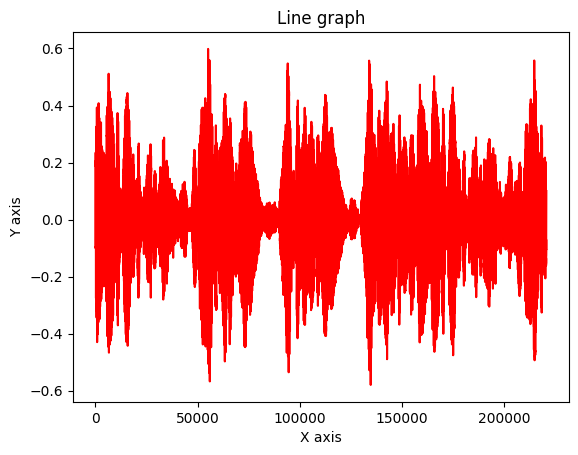

-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+


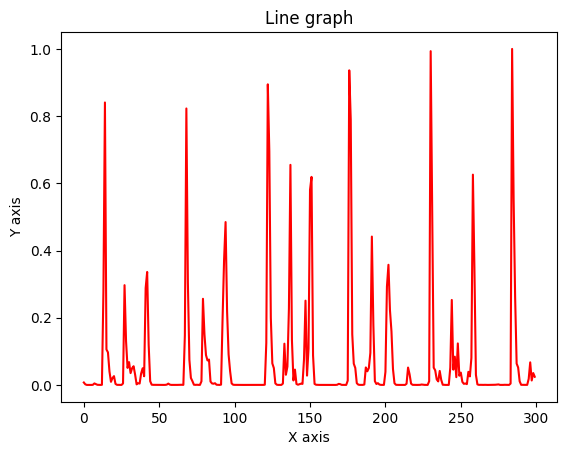

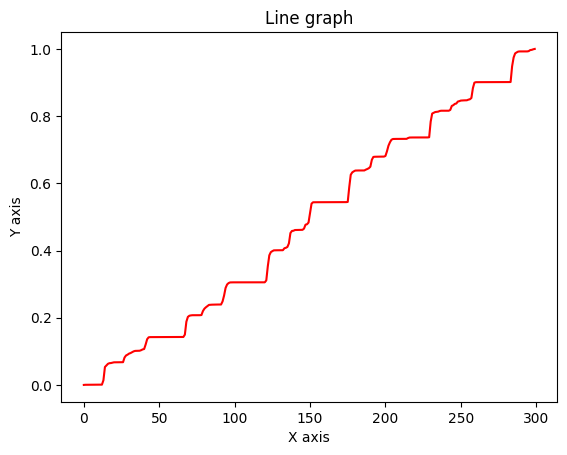

In [5]:
T_sections = []
T_sections_linear = [] #for linear transformation testing
T_linear = np.linspace(0, 1, int(duration * fps)) #for linear transformation testing

for i in range(len(audio_sections)):

    print(i)
    wav_harmonic, wav_percussive = librosa.effects.hpss(audio_sections[i], margin=(5.0, 5.0)) #values above 5.0 don't seem to change anymore
    plot_array(wav_percussive)
    plot_array(wav_harmonic)
    print("-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+")


    # Number of audio samples per frame
    frame_duration = int(sr / fps)

    ## percussive ------------------------------------------------
    # Generate Mel Spectrogram
    spec_raw = librosa.feature.melspectrogram(y=wav_percussive, sr=sr, n_mels=n_mels, hop_length=frame_duration)

    # Obtain maximum value per time-frame
    spec_max = np.amax(spec_raw, axis=0)

    # Normalize all values between 0 and 1
    spec_norm_P = (spec_max - np.min(spec_max)) / np.ptp(spec_max)

    # rescale so its exactly the number of frames we want to generate
    # 3 seconds at 12 fps == 36
    #amplitude_arr = np.resize(spec_norm_P, int(duration * fps))

    #plot_array(amplitude_arr)
    #------------------------------------------------------------

    ## harmonic ------------------------------------------------
    # Generate Mel Spectrogram
    spec_raw_H = librosa.feature.melspectrogram(y=wav_harmonic, sr=sr, n_mels=n_mels, hop_length=frame_duration)

    # Obtain maximum value per time-frame
    spec_max_H = np.amax(spec_raw_H, axis=0)

    # Normalize all values between 0 and 1
    spec_norm_H = (spec_max_H - np.min(spec_max_H)) / np.ptp(spec_max_H)

    # rescale so its exactly the number of frames we want to generate
    # 3 seconds at 12 fps == 36
    #amplitude_arr_H = np.resize(spec_norm_H, int(duration * fps))

    #plot_array(amplitude_arr_H)
    #------------------------------------------------------------

    spec_norm_H_P = 0.00 * spec_norm_H + 1.00 * spec_norm_P # change depending on the song (default 0.20H - 0.80P)

    amplitude_arr_H_P = np.resize(spec_norm_H_P, int(audio_sections_duration[i] * fps))#amplitude_arr_H_P = np.resize(spec_norm_H_P, int(duration * fps))

    plot_array(amplitude_arr_H_P)

    # Cumulative sum of audio energy
    T = np.cumsum(amplitude_arr_H_P)

    # Normalize values of T against last element
    T /= T[-1]

    # 0th element not always exactly 0.0. Enforcing that here.
    T[0] = 0.0

    plot_array(T)

    T_sections.append(T)

    T_sections_linear.append(T_linear) #for linear transformation testing

#Audio(wav_harmonic, rate=sr)
Audio(wav_percussive, rate=sr)



In [6]:
import torch
from diffusers import StableDiffusionImageVariationPipeline
from PIL import Image
from torchvision import transforms
import numpy as np
import os
from pathlib import Path

# Device setup
device = "cuda"

output_dir = Path('images_walk_with_audio') # change output path
output_dir.mkdir(exist_ok=True, parents=True)

# Load the pre-trained model
sd_pipe = StableDiffusionImageVariationPipeline.from_pretrained(
    "lambdalabs/sd-image-variations-diffusers",
    revision="v2.0",
)
sd_pipe = sd_pipe.to(device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors not found


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/871 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/284 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/5.01k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

image_encoder/config.json:   0%|          | 0.00/703 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [7]:

# Load and preprocess the initial image

# Preprocess the images #transforms.Resize((224, 224)
def preprocess_image(image_path, device):
    im = Image.open(image_path).convert("RGB")
    tform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((512, 512), interpolation=transforms.InterpolationMode.BICUBIC, antialias=False
        ),
        transforms.Normalize([0.48145466, 0.4578275, 0.40821073], [0.26862954, 0.26130258, 0.27577711]),
    ])
    return tform(im).unsqueeze(0).to(device)

im1 = "/content/drive/MyDrive/image_samples/sp1.png"
im2 = "/content/drive/MyDrive/image_samples/sp2.png"
im3 = "/content/drive/MyDrive/image_samples/sp3.png"
default = "/content/drive/MyDrive/image_samples/vine-black-painted-swatch.jpg"

path_list = [default, im1, im2, im3]

# Function for encoding images to latent space
def encode_image(pipe, image):
    with torch.no_grad():
        latents = pipe.vae.encode(image).latent_dist.sample()
        latents = 0.18215 * latents
    return latents

def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    """helper function to spherically interpolate two arrays v1 v2"""
    if not isinstance(v0, np.ndarray):
        inputs_are_torch = True
        input_device = v0.device
        v0 = v0.cpu().numpy()
        v1 = v1.cpu().numpy()
    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))

    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1

    if inputs_are_torch:
        v2 = torch.from_numpy(v2).to(input_device)
    return v2

# Interpolate noise vectors and generate image variations
# Interpolate latents and generate images
z = 0
print("loop:start")
i=0
for j in range(len(T_sections)):
    T = T_sections[j]
    #T = T_sections_linear[j] # for linear tests

    if z == 0:
        inp_initial = preprocess_image(path_list[0], device)
        inp_target = preprocess_image(path_list[1], device)
    else:
        #print(path_list[index])
        index = z + 1
        inp_initial = inp_target
        inp_target = preprocess_image(path_list[index], device)
    # Encode initial and target images
    latents_initial = encode_image(sd_pipe, inp_initial)
    latents_target = encode_image(sd_pipe, inp_target)
    for k, t in enumerate(T):

        latents_t = slerp(float(t), latents_initial.flatten(), latents_target.flatten()).view_as(latents_initial)

        with torch.no_grad():
            decoded_image = sd_pipe.vae.decode(latents_t / 0.18215).sample
            image = (decoded_image / 2 + 0.5).clamp(0, 1)
            image = transforms.ToPILImage()(image.squeeze().cpu())
            image.save(os.path.join(output_dir, f'frame{i:06d}.png'))
        i+=1
    z+=1



loop:start


In [8]:
import soundfile as sf

sf.write(output_dir / 'audio_test.wav', wav, samplerate=sr)

In [9]:
#change images_walk_with_audio path # -vf "scale=720:720" \
! ffmpeg \
  -r {fps} \
  -i /content/images_walk_with_audio/frame%06d.png \
  -i /content/images_walk_with_audio/audio_test.wav \
  -c copy \
  -map 0:v:0 \
  -map 1:a:0 \
  -acodec aac \
  -vcodec libx264 \
  -pix_fmt yuv420p \
  output_walk_with_audio.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [10]:
from IPython.display import HTML
from base64 import b64encode

def visualize_video_colab(video_path):
    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

visualize_video_colab('output_walk_with_audio.mp4')

##Result evaluation

##Measuring Audio-Visual Synchrony/ Rhythm Consistency

In [11]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512616 sha256=37f764005816e9c9ba28ee0be32f7dcc5b3feac95d946f403f22ba3c8c9141c2
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


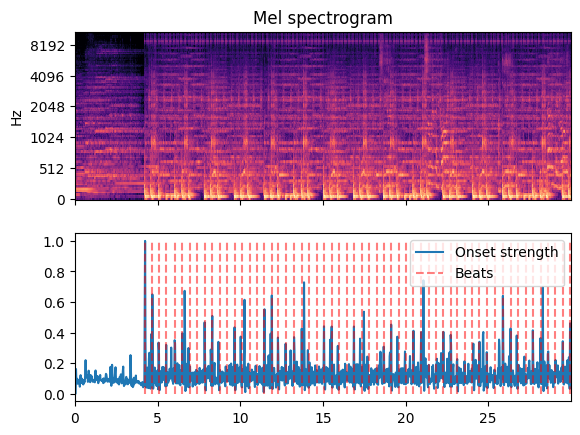

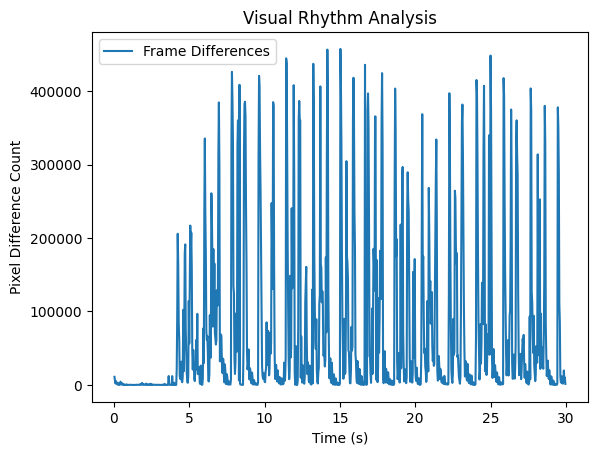

[[ 4.2492517 ]
 [ 4.69043084]
 [ 7.84834467]
 [ 8.31274376]
 [ 9.65950113]
 [11.4706576 ]
 [11.91183673]
 [13.7229932 ]
 [15.06975057]
 [15.53414966]
 [16.88090703]
 [19.13324263]
 [20.48      ]
 [20.94439909]
 [22.29115646]
 [25.89024943]
 [26.35464853]
 [27.7014059 ]
 [29.9537415 ]]
[[ 6.        ]
 [ 7.8       ]
 [ 9.6       ]
 [11.43333333]
 [13.23333333]
 [15.03333333]
 [16.66666667]
 [17.76666667]
 [19.13333333]
 [20.46666667]
 [22.26666667]
 [24.06666667]
 [25.86666667]
 [27.66666667]
 [29.46666667]]
Rhythm Consistency: 0.6851960366503302


In [13]:
import cv2
import librosa
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def detect_beats(audio_path, threshold=0.40):
    y, sr = librosa.load(audio_path)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr, onset_envelope=onset_env)
    beat_times = librosa.frames_to_time(beats, sr=sr)
    onset_env_norm = librosa.util.normalize(onset_env)
    #print(onset_env)
    #print(onset_env_norm)

    significant_beats = beat_times[onset_env_norm[beats] > threshold]

    #https://librosa.org/doc/latest/generated/librosa.beat.beat_track.html
    hop_length = 512
    fig, ax = plt.subplots(nrows=2, sharex=True)
    times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
    M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
    librosa.display.specshow(librosa.power_to_db(M, ref=np.max), y_axis='mel', x_axis='time', hop_length=hop_length,ax=ax[0])
    ax[0].label_outer()
    ax[0].set(title='Mel spectrogram')
    ax[1].plot(times, librosa.util.normalize(onset_env),label='Onset strength')
    ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
    ax[1].legend()

    return significant_beats

beats = detect_beats('/content/drive/MyDrive/audio_samples/1975_bagsy_30sec.wav')

def visual_rhythm_analysis(video_path, threshold=225000, min_interval=1000):
    cap = cv2.VideoCapture(video_path)
    frame_times = []
    prev_frame = None
    last_event_time = 0
    diff_frames_values = []
    every_time_stamp = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if prev_frame is not None:
            diff = cv2.absdiff(prev_frame, frame)
            non_zero_count = np.count_nonzero(diff)
            current_time = cap.get(cv2.CAP_PROP_POS_MSEC)

            diff_frames_values.append(non_zero_count)
            every_time_stamp.append(current_time / 1000)  # Convert to seconds

            if non_zero_count > threshold and (current_time - last_event_time) > min_interval:
                frame_times.append(current_time / 1000)  # Convert to seconds
                last_event_time = current_time

        prev_frame = frame

    cap.release()

    # Plotting the frame differences
    fig, ax = plt.subplots()
    ax.plot(every_time_stamp, diff_frames_values, label='Frame Differences')
    #ax.vlines(frame_times, ymin=min(diff_frames_values), ymax=max(diff_frames_values), color='r', linestyle='--', label='Significant Events')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pixel Difference Count')
    ax.set_title('Visual Rhythm Analysis')
    ax.legend()
    plt.show()

    return frame_times

visual_events = visual_rhythm_analysis("/content/output_walk_with_audio.mp4")

def calculate_rhythm_consistency(beats, visual_events):
    if len(beats) == 0 or len(visual_events) == 0:
        return 0

    # Use DTW to measure similarity between the two sequences
    distance, path = fastdtw(beats, visual_events, dist=euclidean)

    # Normalize the distance by the length of the path to get a consistency score
    rhythm_consistency = 1 / (1 + distance / len(path))
    return rhythm_consistency

beats = np.array(beats).reshape(-1, 1)  # Ensure 2-D array for fastdtw
visual_events = np.array(visual_events).reshape(-1, 1)  # Ensure 2-D array for fastdtw
print(beats)
print(visual_events)
rhythm_consistency = calculate_rhythm_consistency(beats, visual_events)
print("Rhythm Consistency:", rhythm_consistency)
